In [14]:
# 检查 CRS
print("Premature Mortality CRS:", premature_gdf.crs)
print("Twitter CRS:", twitter_gdf.crs)

# 如果 CRS 不同，进行转换
if premature_gdf.crs != twitter_gdf.crs:
    twitter_gdf = twitter_gdf.to_crs(premature_gdf.crs)

# 进行空间连接
joined_gdf = gpd.sjoin(twitter_gdf, premature_gdf, how="inner", op='within')

# 计算每个区域的平均 sentiment 和 dths_rspr0
grouped = joined_gdf.groupby('phn_code').agg({
    'sentiment': 'mean',
    'dths_rspr0': 'mean'
}).reset_index()

# 打印结果
print(grouped)


Premature Mortality CRS: EPSG:4326
Twitter CRS: EPSG:4326
Empty DataFrame
Columns: [phn_code, sentiment, dths_rspr0]
Index: []


/home/ymt/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [1]:
import geopandas as gpd
from shapely.geometry import Point

# 加载 premature mortality 数据
premature_gdf = gpd.read_file('premature_mortality_data.geojson')
print("Premature Mortality Data:")
print(premature_gdf.head())

# 加载 twitter 数据
twitter_gdf = gpd.read_file('twitter_data.geojson')
print("Twitter Data:")
print(twitter_gdf.head())

# 检查 CRS 并转换
print("Premature Mortality CRS:", premature_gdf.crs)
print("Twitter CRS:", twitter_gdf.crs)

if premature_gdf.crs != twitter_gdf.crs:
    twitter_gdf = twitter_gdf.to_crs(premature_gdf.crs)
    print("Converted Twitter CRS:", twitter_gdf.crs)

# 反转 Twitter 数据的坐标顺序
def reverse_coords(geometry):
    if geometry.geom_type == 'Point':
        return Point(geometry.y, geometry.x)
    return geometry

twitter_gdf['geometry'] = twitter_gdf['geometry'].apply(reverse_coords)

# 进行空间连接
joined_gdf = gpd.sjoin(twitter_gdf, premature_gdf, how="inner", op='within')
print("Joined Data:")
print(joined_gdf.head())

# 确保 'dths_rspr0' 和 'sentiment' 列存在于 joined_gdf
if 'dths_rspr0' in joined_gdf.columns and 'sentiment' in joined_gdf.columns:
    # 计算每个区域的平均 sentiment 和 dths_rspr0
    grouped = joined_gdf.groupby('phn_code').agg({
        'sentiment': 'mean',
        'dths_rspr0': 'mean'
    }).reset_index()

    # 打印结果
    print("Grouped Data:")
    print(grouped)
else:
    print("Required columns 'dths_rspr0' and 'sentiment' not found in the joined GeoDataFrame.")


Premature Mortality Data:
  id phn_code  dths_rspr0  dths_rspr1  \
0  0   PHN205  656.799987  110.509373   
1  1   PHN204  298.000000   94.414748   
2  2   PHN110  294.551972  121.181933   
3  3   PHN307  658.000000  120.857624   
4  4   PHN109  618.000000  108.579819   

                                            geometry  
0  POLYGON ((140.96768 -33.98983, 140.96929 -33.9...  
1  MULTIPOLYGON (((146.29448 -39.15607, 146.29257...  
2  POLYGON ((145.34428 -32.68249, 145.25728 -32.6...  
3  MULTIPOLYGON (((149.75775 -22.41293, 149.76343...  
4  MULTIPOLYGON (((152.93518 -31.44644, 152.93501...  
Twitter Data:
  id             tweet_id                created_at lang  \
0  0  1451671570313723907 2021-10-22 22:07:27+00:00   en   
1  1  1451672199178305541 2021-10-22 22:09:57+00:00   en   
2  2  1451671668775026692 2021-10-22 22:07:51+00:00   en   
3  3  1451698288961286146 2021-10-22 23:53:37+00:00   en   
4  4  1451677897807171585 2021-10-22 22:32:36+00:00   en   

               locatio

/home/ymt/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [6]:
import geopandas as gpd
from shapely.geometry import Point
import folium
from folium.plugins import MarkerCluster

# Load premature mortality data
premature_gdf = gpd.read_file('premature_mortality_data.geojson')
print("Premature Mortality Data:")
print(premature_gdf.head())

# Load Twitter data
twitter_gdf = gpd.read_file('twitter_data.geojson')
print("Twitter Data:")
print(twitter_gdf.head())

# Check CRS and transform
print("Premature Mortality CRS:", premature_gdf.crs)
print("Twitter CRS:", twitter_gdf.crs)

if premature_gdf.crs != twitter_gdf.crs:
    twitter_gdf = twitter_gdf.to_crs(premature_gdf.crs)
    print("Converted Twitter CRS:", twitter_gdf.crs)

# Reverse Twitter data coordinates
def reverse_coords(geometry):
    if geometry.geom_type == 'Point':
        return Point(geometry.y, geometry.x)
    return geometry

twitter_gdf['geometry'] = twitter_gdf['geometry'].apply(reverse_coords)

# Aggregate duplicate points
twitter_gdf['coords'] = twitter_gdf['geometry'].apply(lambda geom: (geom.x, geom.y))
twitter_grouped = twitter_gdf.groupby('coords').agg({
    'sentiment': 'sum',
    'geometry': 'first'
}).reset_index()

# Limit sentiment to two decimal places
twitter_grouped['sentiment'] = twitter_grouped['sentiment'].round(2)

# Spatial join
joined_gdf = gpd.sjoin(twitter_gdf, premature_gdf, how="inner", op='within')
print("Joined Data:")
print(joined_gdf.head())

# Ensure 'dths_rspr0' and 'sentiment' columns exist
if 'dths_rspr0' in joined_gdf.columns and 'sentiment' in joined_gdf.columns:
    # Calculate mean sentiment and dths_rspr0 for each region
    grouped = joined_gdf.groupby('phn_code').agg({
        'sentiment': 'mean',
        'dths_rspr0': 'mean'
    }).reset_index()

    # Print grouped data
    print("Grouped Data:")
    print(grouped)

    # Merge grouped data back into premature_gdf
    premature_gdf = premature_gdf.merge(grouped, on='phn_code')
    print("Premature Mortality Data with Grouped Values:")
    print(premature_gdf.head())

    # Create Folium map
    m = folium.Map(location=[premature_gdf.geometry.centroid.y.mean(), premature_gdf.geometry.centroid.x.mean()], zoom_start=6)

    # Add premature_gdf data to map
    folium.Choropleth(
        geo_data=premature_gdf,
        name='choropleth',
        data=premature_gdf,
        columns=['phn_code', 'dths_rspr0_x'],
        key_on='feature.properties.phn_code',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Premature Mortality (dths_rspr0)'
    ).add_to(m)

    # Custom MarkerCluster to display aggregated sentiment values
    class CustomMarkerCluster(MarkerCluster):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

        def add_child(self, child, name=None, index=None):
            super().add_child(child, name, index)
            # Update cluster popups with sentiment sums
            for cluster in self._children.values():
                if isinstance(cluster, folium.plugins.marker_cluster.MarkerCluster):
                    cluster_sum = 0
                    for marker in cluster._children.values():
                        if isinstance(marker, folium.map.Marker):
                            try:
                                sentiment_value = float(marker.popup._content.split(': ')[1])
                                cluster_sum += sentiment_value
                            except:
                                continue
                    cluster.bindPopup(f'Sentiment Sum: {cluster_sum:.2f}')

    # Add custom MarkerCluster
    marker_cluster = CustomMarkerCluster(name='Sentiment Cluster', disableClusteringAtZoom=8).add_to(m)

    # Add aggregated Twitter points to map
    for idx, row in twitter_grouped.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=folium.Popup(f'Sentiment: {row["sentiment"]:.2f}'),
            icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color : black">{row["sentiment"]:.2f}</div>""")
        ).add_to(marker_cluster)

    # Save and display map
    m.save('premature_mortality_twitter_map.html')
    print("Map has been saved as 'premature_mortality_twitter_map.html'")
else:
    print("Required columns 'dths_rspr0' and 'sentiment' not found in the joined GeoDataFrame.")


Premature Mortality Data:
  id phn_code  dths_rspr0  dths_rspr1  \
0  0   PHN205  656.799987  110.509373   
1  1   PHN204  298.000000   94.414748   
2  2   PHN110  294.551972  121.181933   
3  3   PHN307  658.000000  120.857624   
4  4   PHN109  618.000000  108.579819   

                                            geometry  
0  POLYGON ((140.96768 -33.98983, 140.96929 -33.9...  
1  MULTIPOLYGON (((146.29448 -39.15607, 146.29257...  
2  POLYGON ((145.34428 -32.68249, 145.25728 -32.6...  
3  MULTIPOLYGON (((149.75775 -22.41293, 149.76343...  
4  MULTIPOLYGON (((152.93518 -31.44644, 152.93501...  
Twitter Data:
  id             tweet_id                created_at lang  \
0  0  1451671570313723907 2021-10-22 22:07:27+00:00   en   
1  1  1451672199178305541 2021-10-22 22:09:57+00:00   en   
2  2  1451671668775026692 2021-10-22 22:07:51+00:00   en   
3  3  1451698288961286146 2021-10-22 23:53:37+00:00   en   
4  4  1451677897807171585 2021-10-22 22:32:36+00:00   en   

               locatio

/home/ymt/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/tmp/ipykernel_53301/2941819546.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[premature_gdf.geometry.centroid.y.mean(), premature_gdf.geometry.centroid.x.mean()], zoom_start=6)


Joined Data:
  id_left             tweet_id                created_at lang  \
0       0  1451671570313723907 2021-10-22 22:07:27+00:00   en   
1       1  1451672199178305541 2021-10-22 22:09:57+00:00   en   
2       2  1451671668775026692 2021-10-22 22:07:51+00:00   en   
3       3  1451698288961286146 2021-10-22 23:53:37+00:00   en   
4       4  1451677897807171585 2021-10-22 22:32:36+00:00   en   

               location  sentiment                     geometry  \
0   Melbourne, Victoria   0.000000  POINT (145.05314 -37.97257)   
1   Melbourne, Victoria   0.347826  POINT (145.05314 -37.97257)   
2   Melbourne, Victoria  -0.315789  POINT (145.05314 -37.97257)   
3   Melbourne, Victoria   0.000000  POINT (145.05314 -37.97257)   
4  Brisbane, Queensland   0.227273  POINT (152.99320 -27.38214)   

                                      coords  index_right id_right phn_code  \
0  (145.05313534399997, -37.972566514250005)           16       16   PHN203   
1  (145.05313534399997, -37.9725665

In [14]:
import requests
import pandas as pd
import json
from shapely.geometry import shape
import geopandas as gpd

# 定义Fission函数的URL
url = 'http://localhost:31313/permature-twitter'

# 设置相同的请求头
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
}

# 发送GET请求以获取数据
response = requests.get(url, headers=headers)

# 检查响应状态码
print(f"HTTP response status code: {response.status_code}")

if response.status_code == 200:
    try:
        # 直接读取完整响应内容
        data = response.text

        # 打印完整响应内容的前500个字符
        print(f"HTTP response content: {data[:500]}...")

        # 解析JSON数据
        data = json.loads(data)

        # 打印数据结构
        print(json.dumps(data, indent=2))

        # 检查是否存在错误
        if 'error' in data:
            print(f"Error from server: {data['error']}")
        else:
            # 将数据转换为Pandas DataFrame
            suic_df = pd.DataFrame(data['data'])

            # 打印列名
            print(suic_df.columns)

            # 将 geometry 列转换为 shapely 对象
            suic_df['geometry'] = suic_df['geometry'].apply(lambda x: shape(x) if x else None)

            # 转换为 GeoDataFrame
            gdf = gpd.GeoDataFrame(suic_df, geometry='geometry')

            # 保存为 GeoJSON 文件
            geojson_file = 'suic_data.geojson'
            gdf.to_file(geojson_file, driver='GeoJSON')

            print(f"GeoJSON file saved as {geojson_file}")

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Response content: {data[:500]}...")  # 仅打印前500个字符以防止内容过多
else:
    print(f"HTTP request failed with status code {response.status_code}")
    print(f"Error message: {response.text}")


HTTP response status code: 500
HTTP request failed with status code 500
Error message: error sending request to function


In [41]:
file_path = '/home/ymt/ccc/CCC-assignment-2/Backend/suic_data.geojson'
premature_gdf = gpd.read_file(file_path)

In [31]:
premature_gdf 

_id  count_suic  ratio_suic  \
0   hMzehI8BrPb-hKkEoiq8       8.168         592   
1   hczehI8BrPb-hKkEwCoK       7.235         300   
2   hszehI8BrPb-hKkExir9       7.422         308   
3   h8zehI8BrPb-hKkExir9      10.864         181   
4   iMzehI8BrPb-hKkEzCoc       7.705         321   
5   iczehI8BrPb-hKkE0CrL      12.186         329   
6   iszehI8BrPb-hKkE4Cpi      11.499         157   
7   i8zehI8BrPb-hKkE7Sq-      12.203         672   
8   jMzehI8BrPb-hKkE_CqU      13.971         312   
9   jczfhI8BrPb-hKkEAiqx      12.616         134   
10  jszfhI8BrPb-hKkECSrc       8.491         629   
11  j8zfhI8BrPb-hKkECSrc       7.957         533   
12  kMzfhI8BrPb-hKkEDirw       9.956         657   
13  kczfhI8BrPb-hKkEHSpn      13.708         163   
14  kszfhI8BrPb-hKkEJyr-      12.917         336   
15  k8zfhI8BrPb-hKkENSoX      12.207         332   
16  lMzfhI8BrPb-hKkEOyrO      12.360         542   
17  lczfhI8BrPb-hKkEPSpJ      11.941         604   
18  lszfhI8BrPb-hKkEPSpJ      13.766         357   
19  l8zfhI8BrPb-hKkEVSrq      15.476         370   
20  mMzfhI8BrPb-hKkEVyrG      24.773          75   
21  mczfhI8BrPb-hKkEWSqM      14.145         520   
22  mszfhI8BrPb-hKkEYipd      17.687         554   
23  m8zfhI8BrPb-hKkEeCos      12.236         681   
24  nMzfhI8BrPb-hKkEeiqt      14.387         317   
25  nczfhI8BrPb-hKkEoCpS      11.788         575   
26  nszfhI8BrPb-hKkEpyrU      13.466         590   
27  n8zfhI8BrPb-hKkEsyqy      18.388         465   
28  oMzghI8BrPb-hKkECiq-      14.208         336   
29  oczghI8BrPb-hKkEfSqM      19.687         227   
30  oszghI8BrPb-hKkEzCrE       9.053         166   

                                        phn_name  \
0                     Central and Eastern Sydney   
1                                Northern Sydney   
2                                 Western Sydney   
3                          Nepean Blue Mountains   
4                           South Western Sydney   
5                              South Eastern NSW   
6                                    Western NSW   
7           Hunter New England and Central Coast   
8                                    North Coast   
9                                   Murrumbidgee   
10                       North Western Melbourne   
11                             Eastern Melbourne   
12                       South Eastern Melbourne   
13                                     Gippsland   
14                                        Murray   
15                              Western Victoria   
16                                Brisbane North   
17                                Brisbane South   
18                                    Gold Coast   
19                Darling Downs and West Moreton   
20                            Western Queensland   
21  Central Queensland, Wide Bay, Sunshine Coast   
22                           Northern Queensland   
23                                      Adelaide   
24                                    Country SA   
25                                   Perth North   
26                                   Perth South   
27                                    Country WA   
28                                      Tasmania   
29                            Northern Territory   
30                  Australian Capital Territory   

                                             geometry  
0   MULTIPOLYGON (((151.26582 -33.92539, 151.26563...  
1   MULTIPOLYGON (((151.32807 -33.66000, 151.32802...  
2   POLYGON ((150.98395 -33.38793, 150.98396 -33.3...  
3   POLYGON ((150.11620 -32.88529, 150.11859 -32.8...  
4   POLYGON ((150.41818 -33.80965, 150.41805 -33.8...  
5   MULTIPOLYGON (((150.05118 -37.26355, 150.05123...  
6   POLYGON ((146.37539 -28.99878, 146.06778 -28.9...  
7   MULTIPOLYGON (((151.31662 -33.55563, 151.31658...  
8   MULTIPOLYGON (((152.93518 -31.44644, 152.93501...  
9   POLYGON ((145.34428 -32.68249, 145.25728 -32.6...  
10  POLYGON ((144.69948 -37.17629, 144.69948 -37.1...  
11  POLYGON ((145.1

Text(0, 0.5, 'Suicide Death Ratio')

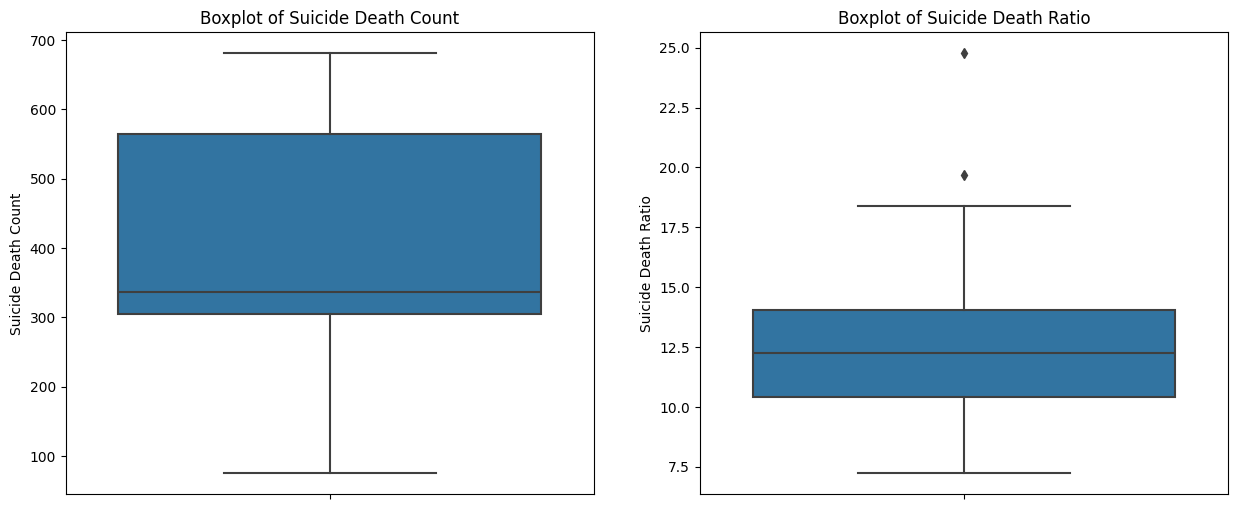

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.boxplot(y=gdf['ratio_suic'], ax=ax[0])
ax[0].set_title('Boxplot of Suicide Death Count')
ax[0].set_ylabel('Suicide Death Count')

sns.boxplot(y=gdf['count_suic'], ax=ax[1])
ax[1].set_title('Boxplot of Suicide Death Ratio')
ax[1].set_ylabel('Suicide Death Ratio')

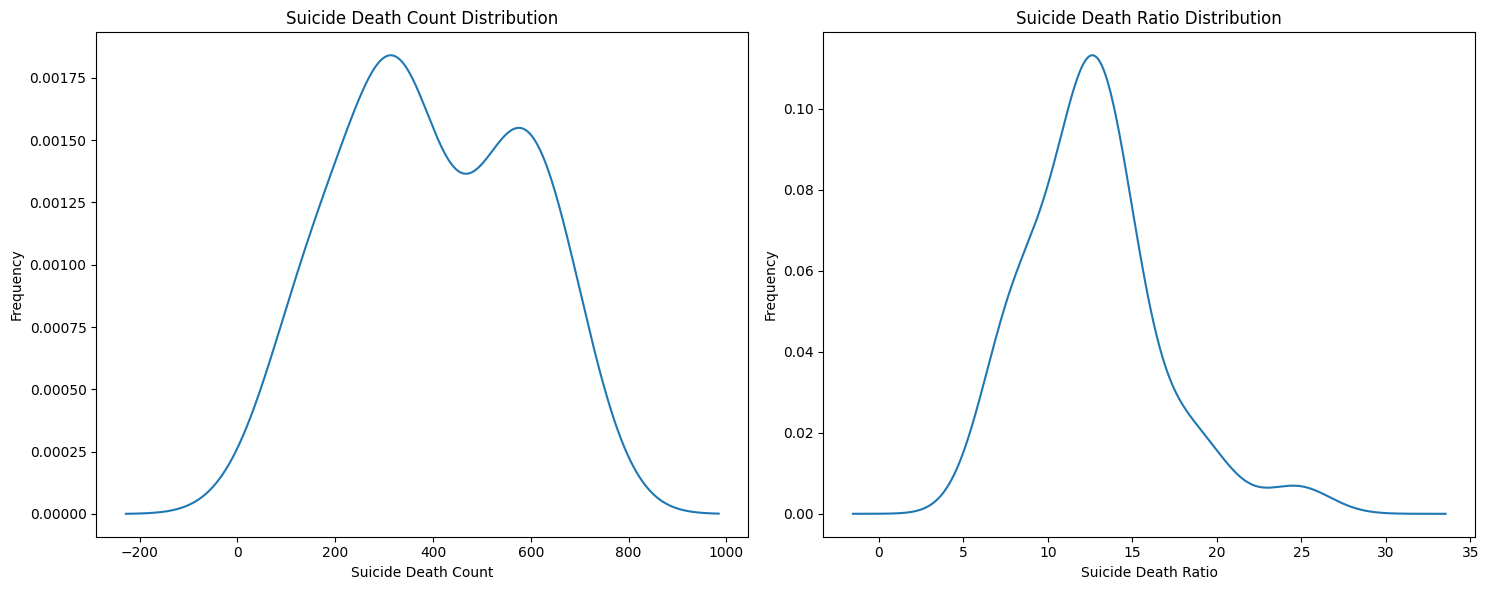

In [51]:

# 基本统计描述
summary_stats = gdf.describe()

# 绘制分布图
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 绘制自杀死亡数量分布
gdf['ratio_suic'].plot(kind='density', ax=ax[0])
ax[0].set_title('Suicide Death Count Distribution')
ax[0].set_xlabel('Suicide Death Count')
ax[0].set_ylabel('Frequency')

# 绘制自杀死亡比率分布
gdf['count_suic'].plot(kind='density', ax=ax[1])
ax[1].set_title('Suicide Death Ratio Distribution')
ax[1].set_xlabel('Suicide Death Ratio')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()



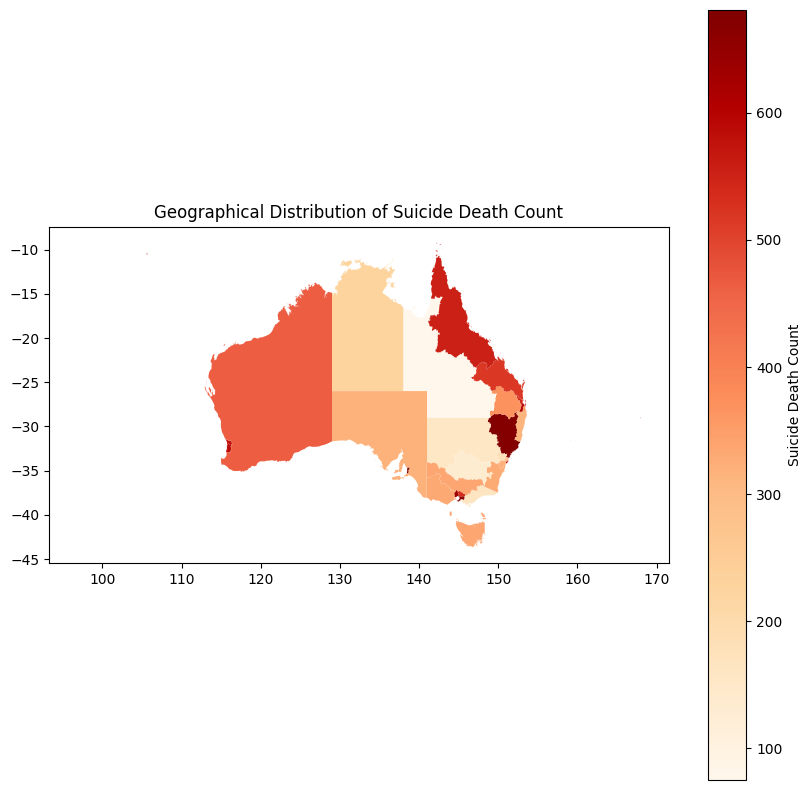

In [52]:
# 绘制地理分布图
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, column='ratio_suic', legend=True, cmap='OrRd', legend_kwds={'label': "Suicide Death Count"})
ax.set_title('Geographical Distribution of Suicide Death Count')
plt.show()

/home/ymt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ymt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


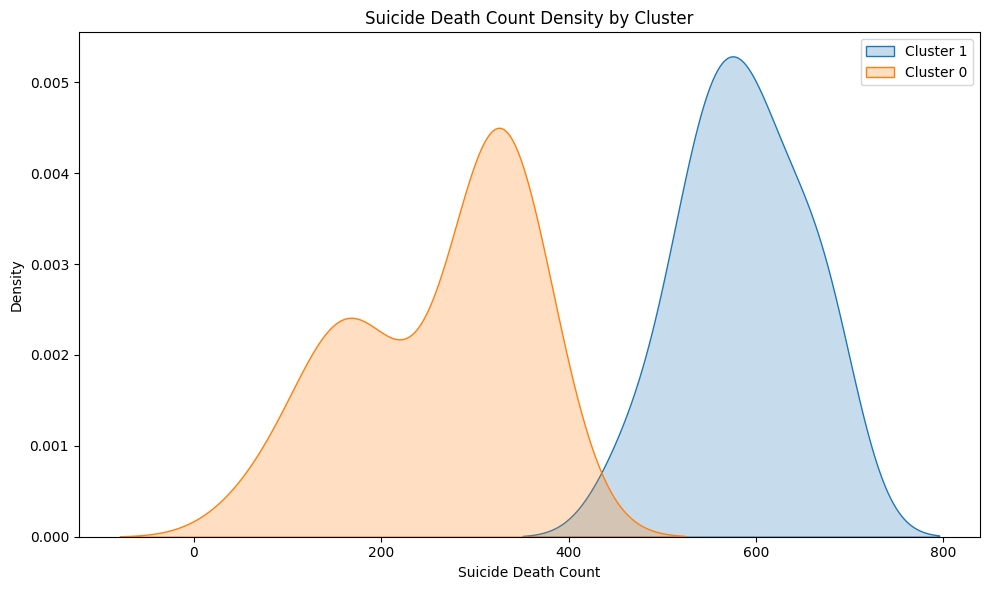

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

data_for_clustering = gdf[['ratio_suic']].dropna()

# 使用KMeans聚类算法
kmeans = KMeans(n_clusters=2)
kmeans.fit(data_for_clustering)
gdf['cluster'] = kmeans.labels_

# 绘制自杀死亡数量分布的密度图
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制每个聚类的密度图
for cluster in gdf['cluster'].unique():
    subset = gdf[gdf['cluster'] == cluster]
    sns.kdeplot(subset['ratio_suic'], ax=ax, label=f'Cluster {cluster}', fill=True)
ax.set_title('Suicide Death Count Density by Cluster')
ax.set_xlabel('Suicide Death Count')
ax.set_ylabel('Density')
ax.legend()

plt.tight_layout()
plt.show()



In [54]:
# 分离两个群体的数据
cluster_0 = gdf[gdf['cluster'] == 0]
cluster_1 = gdf[gdf['cluster'] == 1]

# 计算每个群体的基本统计信息
stats_0 = cluster_0[['ratio_suic']].describe()
stats_1 = cluster_1[['ratio_suic']].describe()

# 显示统计信息
print("Cluster 0 Statistics:")
print(stats_0)

print("\nCluster 1 Statistics:")
print(stats_1)

Cluster 0 Statistics:
       ratio_suic
count   18.000000
mean   262.277778
std     91.643687
min     75.000000
25%    169.750000
50%    310.000000
75%    331.250000
max    370.000000

Cluster 1 Statistics:
       ratio_suic
count   13.000000
mean   585.692308
std     63.621779
min    465.000000
25%    542.000000
50%    590.000000
75%    629.000000
max    681.000000


In [58]:
import pandas as pd
import folium
from folium import GeoJson
from shapely.geometry import shape
import json
import geopandas as gpd

# 确保geometry列中的几何对象是正确的
gdf['geometry'] = gdf['geometry'].apply(shape)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')

# 创建地图对象
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=6)

# 创建GeoJson图层
geojson_layer = GeoJson(
    gdf.to_json(),  # 将 GeoDataFrame 转换为 GeoJSON 格式
    style_function=lambda x: {
        'fillColor': '#3186cc',  # 可以根据 'dths_rspr0' 的值设置不同的颜色
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.6
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['phn_name', 'ratio_suic'],  # 这里可以设置为需要显示的字段
        aliases=['PHN Name:', 'Deaths by Suicide:'],  # 字段的别名
        localize=True
    )
)
geojson_layer.add_to(m)



/tmp/ipykernel_720/3182401680.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=6)


In [59]:
m.save('premature_mortality_map.html')

In [2]:
import requests
import pandas as pd
import json
from shapely.geometry import shape
import geopandas as gpd

# 定义Fission函数的URL
url = 'http://localhost:31313/twitter-data'

# 设置相同的请求头
headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
}

# 发送GET请求以获取数据
response = requests.get(url, headers=headers)

# 检查响应状态码
print(f"HTTP response status code: {response.status_code}")

if response.status_code == 200:
    try:
        # 直接读取完整响应内容
        data = response.text

        # 打印完整响应内容的前500个字符
        print(f"HTTP response content: {data[:500]}...")

        # 解析JSON数据
        data = json.loads(data)

        # 打印数据结构
        print(json.dumps(data, indent=2))

        # 检查是否存在错误
        if 'error' in data:
            print(f"Error from server: {data['error']}")
        else:
            # 提取GeoJSON数据
            geojson_data = data['data']

            # 创建GeoDataFrame
            gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

            # 保存为 GeoJSON 文件
            geojson_file = 'twitter-data.geojson'
            gdf.to_file(geojson_file, driver='GeoJSON')

            print(f"GeoJSON file saved as {geojson_file}")

    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Response content: {data[:500]}...")  # 仅打印前500个字符以防止内容过多
else:
    print(f"HTTP request failed with status code {response.status_code}")
    print(f"Error message: {response.text}")


HTTP response status code: 200
HTTP response content: {"status_code": 200, "data": {"type": "FeatureCollection", "features": [{"type": "Feature", "geometry": {"type": "Point", "coordinates": [150.93197479999998, -33.84824400225]}, "properties": {"tweet_id": "1406782226214244353", "created_at": "2021-06-21T01:13:14.000Z", "lang": "en", "location": "Sydney, New South Wales", "sentiment": -0.125}}, {"type": "Feature", "geometry": {"type": "Point", "coordinates": [145.053135344, -37.972566514250005]}, "properties": {"tweet_id": "1406802872671477762", "...
{
  "status_code": 200,
  "data": {
    "type": "FeatureCollection",
    "features": [
      {
        "type": "Feature",
        "geometry": {
          "type": "Point",
          "coordinates": [
            150.93197479999998,
            -33.84824400225
          ]
        },
        "properties": {
          "tweet_id": "1406782226214244353",
          "created_at": "2021-06-21T01:13:14.000Z",
          "lang": "en",
          "locat

In [39]:
import geopandas as gpd

# 加载GeoJSON文件
file_path = '/home/ymt/ccc/CCC-assignment-2/Backend/twitter-data.geojson'
twitter_gdf = gpd.read_file(file_path)

# 显示数据的基本信息
print(twitter_gdf.info())
print(twitter_gdf.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweet_id    10000 non-null  object             
 1   created_at  10000 non-null  datetime64[ns, UTC]
 2   lang        10000 non-null  object             
 3   location    10000 non-null  object             
 4   sentiment   10000 non-null  float64            
 5   geometry    10000 non-null  geometry           
dtypes: datetime64[ns, UTC](1), float64(1), geometry(1), object(3)
memory usage: 468.9+ KB
None
              tweet_id                created_at lang  \
0  1406782226214244353 2021-06-21 01:13:14+00:00   en   
1  1406802872671477762 2021-06-21 02:35:16+00:00   en   
2  1406928132813168646 2021-06-21 10:53:00+00:00   en   
3  1406773506394583041 2021-06-21 00:38:35+00:00   en   
4  1406814047354318848 2021-06-21 03:19:40+00:00   en   

                    lo

In [3]:
# 检查缺失值
print(twitter_gdf.isnull().sum())

# 确保geometry列中的几何对象是正确的
twitter_gdf['geometry'] = twitter_gdf['geometry'].apply(lambda x: shape(x) if isinstance(x, dict) else x)
twitter_gdf = gpd.GeoDataFrame(twitter_gdf, geometry='geometry')

# 提取经纬度数据
twitter_gdf['longitude'] = twitter_gdf.geometry.x
twitter_gdf['latitude'] = twitter_gdf.geometry.y

# 将 Timestamp 类型的列转换为字符串
if 'created_at' in twitter_gdf.columns:
    twitter_gdf['created_at'] = twitter_gdf['created_at'].astype(str)

# 显示数据的基本信息和前几行
print(twitter_gdf.info())
print(twitter_gdf.head())


tweet_id      0
created_at    0
lang          0
location      0
sentiment     0
geometry      0
dtype: int64
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tweet_id    10000 non-null  object  
 1   created_at  10000 non-null  object  
 2   lang        10000 non-null  object  
 3   location    10000 non-null  object  
 4   sentiment   10000 non-null  float64 
 5   geometry    10000 non-null  geometry
 6   longitude   10000 non-null  float64 
 7   latitude    10000 non-null  float64 
dtypes: float64(3), geometry(1), object(4)
memory usage: 625.1+ KB
None
              tweet_id                 created_at lang  \
0  1406782226214244353  2021-06-21 01:13:14+00:00   en   
1  1406802872671477762  2021-06-21 02:35:16+00:00   en   
2  1406928132813168646  2021-06-21 10:53:00+00:00   en   
3  1406773506394583041  2021-06-21 00:38:35+00:00   

/home/ymt/miniconda3/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


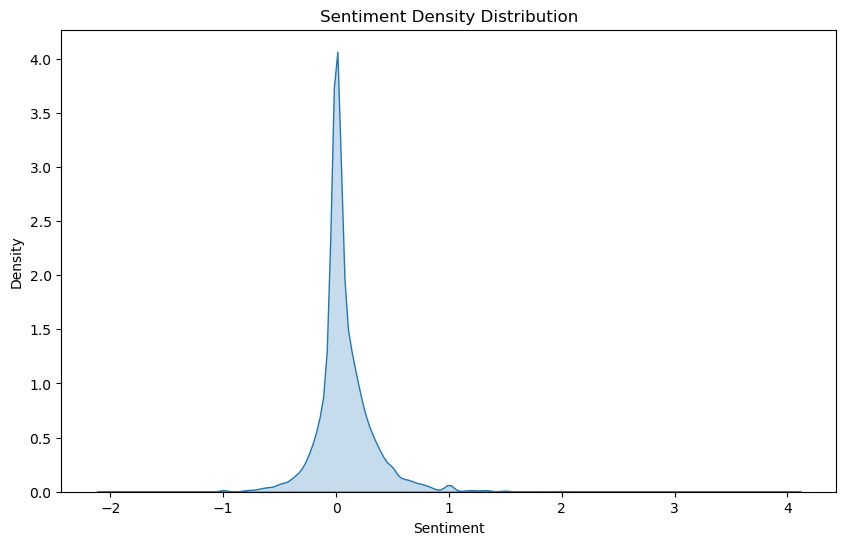

In [9]:
import pandas as pd
import folium
from folium import GeoJson
from shapely.geometry import shape, box, Point
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# 绘制情感分布的密度图
plt.figure(figsize=(10, 6))
sns.kdeplot(twitter_gdf['sentiment'], fill=True)
plt.title('Sentiment Density Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Density')   
plt.show()



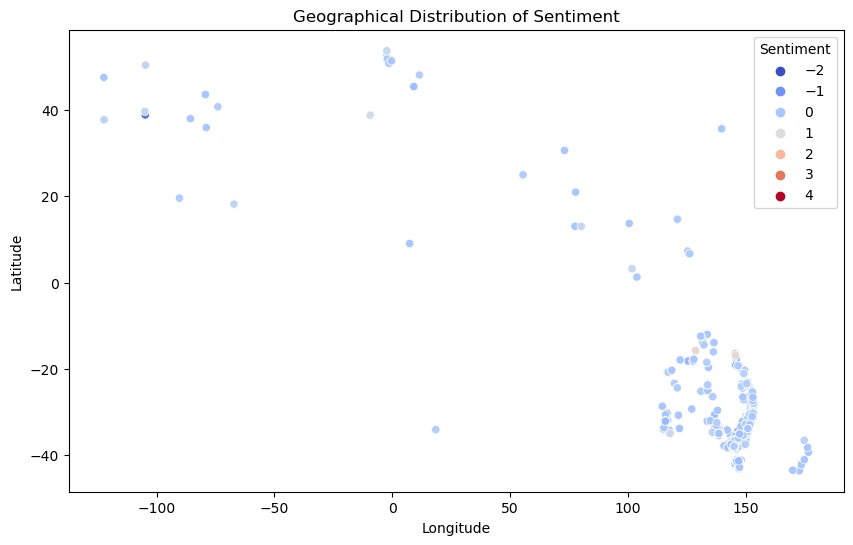

In [10]:
# 绘制地理位置和情感之间的关系
plt.figure(figsize=(10, 6))
sns.scatterplot(data=twitter_gdf, x='longitude', y='latitude', hue='sentiment', palette='coolwarm')
plt.title('Geographical Distribution of Sentiment')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Sentiment')
plt.show()

In [28]:
from folium.plugins import MarkerCluster
from sklearn.cluster import DBSCAN
m = folium.Map(location=[0, 0], zoom_start=2)

# 创建一个 MarkerCluster 层
marker_cluster = MarkerCluster().add_to(m)

# 假设 gdf 包含地理数据
for idx, row in twitter_gdf.iterrows():
    # 提取经纬度
    lon,lat  = row['geometry'].centroid.coords[0]
    # 添加标记
    folium.Marker([lat,lon], 
                  popup=f"Sentiment Score: {row['sentiment']}").add_to(marker_cluster)

# 保存地图
m.save('twitter_data_map.html')

In [32]:
# 检查 CRS 并转换
print("Premature Mortality CRS:", premature_gdf.crs)
print("Twitter CRS:", twitter_gdf.crs)


Premature Mortality CRS: EPSG:4326
Twitter CRS: EPSG:4326


In [37]:
import geopandas as gpd
import folium

# 检查和确保 CRS 一致
if twitter_gdf.crs != premature_gdf.crs:
    twitter_gdf = twitter_gdf.to_crs(premature_gdf.crs)

# 聚合重复点的位置
twitter_gdf['coords'] = twitter_gdf['geometry'].apply(lambda geom: (geom.x, geom.y))
twitter_grouped = twitter_gdf.groupby('coords').agg({
    'sentiment': 'sum',
    'geometry': 'first'
}).reset_index()

# 将 sentiment 限制为两位小数
twitter_grouped['sentiment'] = twitter_grouped['sentiment'].round(2)

# 检查 premature_gdf 的几何类型
print("Premature GDF Geometry Type:")
print(premature_gdf.geom_type.unique())

# 进行空间连接
joined_gdf = gpd.sjoin(twitter_gdf, premature_gdf, how="inner", op='within')

print("Joined Data:")
print(joined_gdf.head())

# 确保 'dths_rspr0' 和 'sentiment' 列存在于 joined_gdf
if 'dths_rspr0' in joined_gdf.columns and 'sentiment' in joined_gdf.columns:
    # 计算每个区域的平均 sentiment 和 dths_rspr0
    grouped = joined_gdf.groupby('phn_code').agg({
        'sentiment': 'mean',
        'dths_rspr0': 'mean'
    }).reset_index()

    # 打印 grouped 数据
    print("Grouped Data:")
    print(grouped)

    # 将 grouped 数据合并回 premature_gdf 中
    premature_gdf = premature_gdf.merge(grouped, on='phn_code')
    print("Premature Mortality Data with Grouped Values:")
    print(premature_gdf.head())

    # 创建 Folium 地图
    m = folium.Map(location=[premature_gdf.geometry.centroid.y.mean(), premature_gdf.geometry.centroid.x.mean()], zoom_start=6)

    # 添加 premature_gdf 数据到地图
    folium.Choropleth(
        geo_data=premature_gdf,
        name='choropleth',
        data=premature_gdf,
        columns=['phn_code', 'dths_rspr0_x'],
        key_on='feature.properties.phn_code',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Premature Mortality (dths_rspr0)'
    ).add_to(m)

    # 添加 Twitter 点数据到地图，显示聚合后的 sentiment 数值
    for idx, row in twitter_grouped.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=f'Sentiment Sum: {row["sentiment"]}',
            icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color : black">{row["sentiment"]:.2f}</div>""")
        ).add_to(m)

    # 保存并显示地图
    m.save('premature_mortality_twitter_map.html')
    print("Map has been saved as 'premature_mortality_twitter_map.html'")
else:
    print("Required columns 'dths_rspr0' and 'sentiment' not found in the joined GeoDataFrame.")


Premature GDF Geometry Type:
['MultiPolygon' 'Polygon']
Joined Data:
Empty GeoDataFrame
Columns: [tweet_id, created_at, lang, location, sentiment, geometry, longitude, latitude, cluster, coords, index_right, _id, count_suic, ratio_suic, phn_name]
Index: []
Required columns 'dths_rspr0' and 'sentiment' not found in the joined GeoDataFrame.


/home/ymt/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [52]:
import geopandas as gpd
import folium

# 加载数据
twitter_gdf = gpd.read_file('/home/ymt/ccc/CCC-assignment-2/Backend/twitter-data.geojson')
premature_gdf = gpd.read_file('/home/ymt/ccc/CCC-assignment-2/Backend/suic_data.geojson')

# 检查和确保 CRS 一致
if twitter_gdf.crs != premature_gdf.crs:
    twitter_gdf = twitter_gdf.to_crs(premature_gdf.crs)

# 打印 GeoDataFrame 的范围
print("Twitter GDF bounds:")
print(twitter_gdf.total_bounds)
print("Premature GDF bounds:")
print(premature_gdf.total_bounds)

# 检查范围重叠
twitter_bounds = twitter_gdf.total_bounds
premature_bounds = premature_gdf.total_bounds

if (twitter_bounds[0] > premature_bounds[2] or twitter_bounds[2] < premature_bounds[0] or
        twitter_bounds[1] > premature_bounds[3] or twitter_bounds[3] < premature_bounds[1]):
    print("Twitter points are outside the bounds of the premature data polygons.")
else:
    print("Twitter points are within the bounds of the premature data polygons.")

# 聚合重复点的位置
twitter_gdf['coords'] = twitter_gdf['geometry'].apply(lambda geom: (geom.x, geom.y))
twitter_grouped = twitter_gdf.groupby('coords').agg({
    'sentiment': 'sum',
    'geometry': 'first'
}).reset_index()

# 将 sentiment 限制为两位小数
twitter_grouped['sentiment'] = twitter_grouped['sentiment'].round(2)

# 检查 premature_gdf 的几何类型
print("Premature GDF Geometry Type:")
print(premature_gdf.geom_type.unique())

# 打印一些数据点
print("Twitter GDF Sample:")
print(twitter_gdf.head())
print("Premature GDF Sample:")
print(premature_gdf.head())

# 进行空间连接
joined_gdf = gpd.sjoin(twitter_gdf, premature_gdf, how="inner", op='within')

print("Joined Data:")
print(joined_gdf.head())

# 确保 'ratio_suic' 和 'sentiment' 列存在于 joined_gdf
if 'ratio_suic' in joined_gdf.columns and 'sentiment' in joined_gdf.columns:
    # 计算每个区域的平均 sentiment 和 dths_rspr0
    grouped = joined_gdf.groupby('phn_name').agg({
        'sentiment': 'mean',
        'ratio_suic': 'mean'
    }).reset_index()

    # 打印 grouped 数据
    print("Grouped Data:")
    print(grouped)

    # 将 grouped 数据合并回 premature_gdf 中
    premature_gdf = premature_gdf.merge(grouped, on='phn_name')
    print("Premature Mortality Data with Grouped Values:")
    print(premature_gdf.head())
     # 创建 Folium 地图
    m = folium.Map(location=[premature_gdf.geometry.centroid.y.mean(), premature_gdf.geometry.centroid.x.mean()], zoom_start=6)

    # 添加 premature_gdf 数据到地图
    folium.Choropleth(
        geo_data=premature_gdf,
        name='choropleth',
        data=premature_gdf,
        columns=['phn_name', 'ratio_suic_x'],
        key_on='feature.properties.phn_name',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Premature Mortality (ratio_suic)'
    ).add_to(m)

    # Custom MarkerCluster to display aggregated sentiment values
    class CustomMarkerCluster(MarkerCluster):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)

        def add_child(self, child, name=None, index=None):
            super().add_child(child, name, index)
            # Update cluster popups with sentiment sums
            for cluster in self._children.values():
                if isinstance(cluster, folium.plugins.marker_cluster.MarkerCluster):
                    cluster_sum = 0
                    for marker in cluster._children.values():
                        if isinstance(marker, folium.map.Marker):
                            try:
                                sentiment_value = float(marker.popup._content.split(': ')[1])
                                cluster_sum += sentiment_value
                            except:
                                continue
                    cluster.bindPopup(f'Sentiment Sum: {cluster_sum:.2f}')
    marker_cluster = CustomMarkerCluster(name='Sentiment Cluster', disableClusteringAtZoom=8).add_to(m)

    # 添加 Twitter 点数据到地图，显示聚合后的 sentiment 数值
    for idx, row in twitter_grouped.iterrows():
        folium.Marker(
            location=[row.geometry.y, row.geometry.x],
            popup=folium.Popup(f'Sentiment: {row["sentiment"]:.2f}'),
            icon=folium.DivIcon(html=f"""<div style="font-size: 12pt; color : black">{row["sentiment"]:.2f}</div>""")
        ).add_to(marker_cluster)

    # 保存并显示地图
    m.save('premature_mortality_twitter_map.html')
    print("Map has been saved as 'premature_mortality_twitter_map.html'")
else:
    print("Required columns 'ratio_suic' and 'sentiment' not found in the joined GeoDataFrame.")

   

Twitter GDF bounds:
[-122.3306024  -43.6457815  176.620187    53.7942165]
Premature GDF bounds:
[ 96.816941 -43.74051  167.998035  -9.142176]
Twitter points are within the bounds of the premature data polygons.
Premature GDF Geometry Type:
['MultiPolygon' 'Polygon']
Twitter GDF Sample:
              tweet_id                created_at lang  \
0  1406782226214244353 2021-06-21 01:13:14+00:00   en   
1  1406802872671477762 2021-06-21 02:35:16+00:00   en   
2  1406928132813168646 2021-06-21 10:53:00+00:00   en   
3  1406773506394583041 2021-06-21 00:38:35+00:00   en   
4  1406814047354318848 2021-06-21 03:19:40+00:00   en   

                    location  sentiment                     geometry  \
0    Sydney, New South Wales  -0.125000  POINT (150.93197 -33.84824)   
1        Melbourne, Victoria   0.100000  POINT (145.05314 -37.97257)   
2        Melbourne, Victoria  -0.153846  POINT (145.05314 -37.97257)   
3     Gold Coast, Queensland   0.357143  POINT (153.36936 -27.95422)   
4  Adelaid

/home/ymt/miniconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


                    _id  count_suic  ratio_suic_x                    phn_name  \
0  hMzehI8BrPb-hKkEoiq8       8.168           592  Central and Eastern Sydney   
1  hczehI8BrPb-hKkEwCoK       7.235           300             Northern Sydney   
2  h8zehI8BrPb-hKkExir9      10.864           181       Nepean Blue Mountains   
3  iMzehI8BrPb-hKkEzCoc       7.705           321        South Western Sydney   
4  iczehI8BrPb-hKkE0CrL      12.186           329           South Eastern NSW   

                                            geometry  sentiment  ratio_suic_y  
0  MULTIPOLYGON (((151.26582 -33.92539, 151.26563...   0.057143         592.0  
1  MULTIPOLYGON (((151.32807 -33.66000, 151.32802...   0.017682         300.0  
2  POLYGON ((150.11620 -32.88529, 150.11859 -32.8...   0.070317         181.0  
3  POLYGON ((150.41818 -33.80965, 150.41805 -33.8...   0.069538         321.0  
4  MULTIPOLYGON (((150.05118 -37.26355, 150.05123...   0.045360         329.0  


/tmp/ipykernel_46774/2812200698.py:71: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[premature_gdf.geometry.centroid.y.mean(), premature_gdf.geometry.centroid.x.mean()], zoom_start=6)


Map has been saved as 'premature_mortality_twitter_map.html'


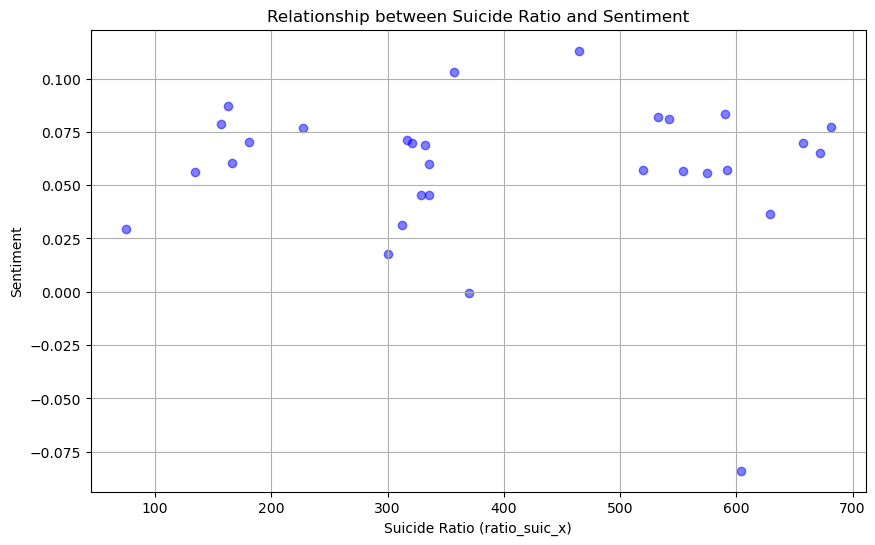

In [54]:
data = premature_gdf[['ratio_suic_x', 'sentiment']]

# 创建散点图
plt.figure(figsize=(10, 6))
plt.scatter(data['ratio_suic_x'], data['sentiment'], c='blue', alpha=0.5)
plt.title('Relationship between Suicide Ratio and Sentiment')
plt.xlabel('Suicide Ratio (ratio_suic_x)')
plt.ylabel('Sentiment')
plt.grid(True)
plt.show()

In [55]:
correlation = data.corr()
print("Correlation matrix:")
print(correlation)


Correlation matrix:
              ratio_suic_x  sentiment
ratio_suic_x      1.000000  -0.070562
sentiment        -0.070562   1.000000


In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data[['ratio_suic_x']])
y_scaled = scaler.fit_transform(data[['sentiment']])

In [61]:
from scipy.stats import pearsonr
# 计算皮尔逊相关系数
pearson_corr, pearson_p_value = pearsonr(data['ratio_suic_x'], data['sentiment'])
print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}")

Pearson correlation: -0.07056191525647182, p-value: 0.7109923658019901
